In [2]:
from google.colab import files
#select HMC.py and Model.py, generator_opt_w.pt, data_file.pt
uploaded = files.upload()


Saving HMC.py to HMC.py


In [3]:
#Installation of the Hamiltorch package from a git repo (hence this notebook will work under Linux, if you dont have the easiest way is to use google colab)
!pip install git+https://github.com/AdamCobb/hamiltorch.git

  Cloning https://github.com/AdamCobb/hamiltorch.git to /tmp/pip-req-build-hwljhi_0
  Running command git clone --filter=blob:none --quiet https://github.com/AdamCobb/hamiltorch.git /tmp/pip-req-build-hwljhi_0
  Resolved https://github.com/AdamCobb/hamiltorch.git to commit 19b627b2aabc77c1b4b78db0f860372eb1bf9778
  Preparing metadata (setup.py) ... done
  Created wheel for hamiltorch: filename=hamiltorch-0.4.1-py3-none-any.whl size=20806 sha256=2513105f99b29b770463381e43c0490ed1858a0f5007c5ca67b8a5b1b281f38b
  Stored in directory: /tmp/pip-ephem-wheel-cache-v2zm93hh/wheels/84/dc/58/ea5071d4fab88c8e3ed8d1adad1a82d50a282c06b8ee74228d
Successfully built hamiltorch


In [4]:
import torch
import hamiltorch
import numpy as np
import matplotlib.pyplot as plt
from HMC import latent_posterior, hamiltonian_MC, compute_MAP
from model_file import Generator

Running on cpu


<ipython-input-6-64e070b301cf>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_opt_w.pt"))
<ipython-input-6-64e070b301cf>:2

Observation error: 0.8391
Full error: 0.9206
Sampling (Sampler.HMC; Integrator.IMPLICIT)


Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.15347620844841003

Acceptance Rate 0.29


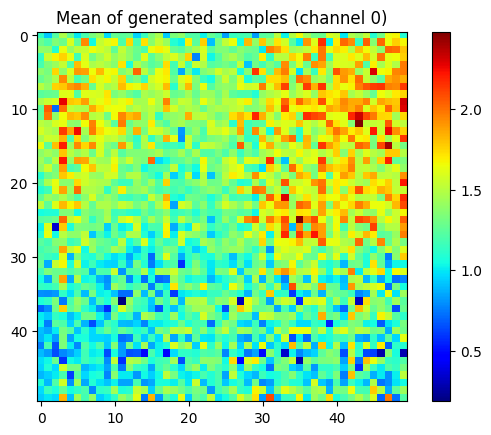

In [6]:
def observation_operator(data):

    sensor_coords = [(x, y) for x in range(0,50,5) for y in range(0,50,5)]
    v1 = data[0]  # (50,50)
    obs_values = []
    for (x, y) in sensor_coords:
        obs_values.append(v1[x, y])
    obs_values = torch.stack(obs_values)  # shape (N_y,)
    return obs_values


def add_noise_to_data(obs, noise_mean, noise_std):
    obs_noise = torch.normal(mean=noise_mean, std=noise_std)
    obs += obs_noise
    return obs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on {device}')

generator = Generator(z_dim=150).to(device)
generator.load_state_dict(torch.load("generator_opt_w.pt"))
generator.eval()

#retrieve true_datas
state_path = 'data_file.pt'
true_state =  torch.load(state_path).to(device)  # (4,50,50)

observations = observation_operator(true_state)
observations = observations.to(device)

# Construct Y (the noisy observation/measurement from the true data)
obs_std = 1e-1
noise_mean = torch.zeros_like(observations, device=device) #vecteur
noise_std = obs_std * torch.ones_like(observations, device=device) #vecteur mais mat cov ?
observations = add_noise_to_data(observations, noise_mean, noise_std)

# MAP
z_init = torch.randn(1, 150, requires_grad=True, device=device)
z_map = compute_MAP(z=z_init,
                    observations=observations,
                    generator=generator,
                    obs_operator=lambda x: observation_operator(x),
                    obs_std=obs_std,
                    num_iters=500)


obs_error = torch.linalg.norm(observations - observation_operator(generator(z_map)[0])) / torch.linalg.norm(observations)
full_error = torch.linalg.norm(true_state - generator(z_map)[0]) / torch.linalg.norm(true_state)
print(f'Observation error: {obs_error:0.4f}')
print(f'Full error: {full_error:0.4f}')

# HMC
posterior_params = {
    'generator': generator,
    'obs_operator': lambda x: observation_operator(x),
    'observations': observations,
    'prior_mean': torch.zeros(150, device=device),
    'prior_std': torch.ones(150, device=device),
    'noise_mean': noise_mean,
    'noise_std': noise_std
}

HMC_params = {
    'num_samples': 20000,
    'step_size': 0.5,
    'num_steps_per_sample': 5,
    'burn': 12000,
    'integrator': hamiltorch.Integrator.IMPLICIT,
    'sampler': hamiltorch.Sampler.HMC_NUTS,
    'desired_accept_rate': 0.3
}

z_samples = hamiltonian_MC(z_init=torch.squeeze(z_map),
                            posterior_params=posterior_params,
                            HMC_params=HMC_params)

# Now that we have sample sufficiently enough z|y, we can generate u|y with G_theta(z|y)
generated_states = []
with torch.no_grad():
    for z_s in z_samples:
        gen_s = generator(z_s.view(1,-1))[0]
        generated_states.append(gen_s.cpu().numpy())

generated_states = np.array(generated_states)  #(num_samples,4,50,50)
mean_field = np.mean(generated_states, axis=0)


true_v1 = true_state.detach().cpu().numpy()

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(true_v1[0], cmap='jet', origin='lower', extent=[0,1,0,1], vmin = 0, vmax = 2.0)
plt.colorbar()
plt.title("True v1")

plt.subplot(1, 2, 2)
plt.imshow(mean_field[0,:,:], cmap='jet', origin='lower', extent=[0,1,0,1], vmin = 0, vmax = 2.0)
plt.colorbar()
plt.title("Mean Generated v1")

plt.tight_layout()
plt.show()